# Coursera Capstone

This is a notebook that will be used for my capstone project in a **IBM Data Science Professional Certificate**.

In [1]:
import folium
import matplotlib
import mpmath as mpm
import numpy as np
import pandas as pd
import requests

from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
from sklearn.cluster import DBSCAN 
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler 

%matplotlib inline

# Exploration of Toronto

In this notebook, Wikipedia is scraped for geospatial data on the city of Toronto. This data is then be analyzed in python.

The wikipedia page of interest contains postal codes as well as the names of the corresponding borough and neighborhood within the City of Toronoto. These data are are wrangled out of the html-bog and into a beautiful dataframe. This is done quickly with a call to **pd.read_html** and here BeautifulSoup is used to do the same.

***
## BEGIN PART 1 ##


## Wranglin'

The process here is simple. A http-request is made to Wikipedia. The resultant html doc is incorporated into a BeautifulSoup object, parsed, and looped into a pandas frame.

#### The humble HTTP request ####
A http request is made. The status is checked.

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
html_doc = requests.get(url)

if html_doc.status_code != 200:
    print(str(html_doc.status_code),'Trouble!')
else:
    print(str(html_doc.status_code), 'OK')

200 OK


#### BeautifulSoup ####
The HTML document is incorporated into a new BeautifulSoup object "soup." The document is inspected for accuracy and commented out here for clarity.

In [3]:
soup = BeautifulSoup(html_doc.text,'html.parser')
#print(soup.prettify())

#### Soup in a loop ####

There are multiple tables in the page and the first one is of interest. Let's loop through each < tr > table-row tag with BeautifulSoup and then .split() on newlines, wrangling the data into the DataFrame object. 

In [79]:
table = soup.find_all('table')[0]
df = pd.DataFrame(columns=['Postal_Code',
                           'Borough',
                           'Neighborhood'])

for tr in table.find_all('tr')[1:]:
    tds =tr.text.split("\n")
    df = df.append({'Postal_Code':tds[1],
                    'Borough':tds[3],
                    'Neighborhood':tds[5]},
                   ignore_index=True) 
df[0:5]

,Postal_Code,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


Looks good.
## Cleaning
#### Drop NAs ####
There are some *Postal Codes* that have not been assigned to a *Borough*. Let's get rid of them.

In [80]:
df = df[df['Borough'] != 'Not assigned']
df[0:5]

,Postal_Code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


It appears that some integrity has been lost in our index by dropping those rows. The index is reset.

In [81]:
df.reset_index(drop=True, inplace=True)

#### Inspect Neigboghoods####
Are there any *Boroughs* with *Neighbourhoods* that have not been assigned?

In [82]:
if df[df['Neighborhood'] == 'Not assigned'].empty:
    print("There are not!")
else:
    print("Keep cleaning!")

There are not!


#### Combining Neighborhoods ####
More than one *Neighborhood* can exist for each *Postal Code*. For each *Postal Code*, all corresponding neighborhoods are combined into a comma-separated list. The existing *Neighborhood* data are replaced with the comma-separated list of neighborhoods for each *Postal Code*.

In [83]:
groups = df.groupby(['Postal_Code','Borough'])['Neighborhood']
df = groups.apply(','.join).reset_index()
df

,Postal_Code,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
...,...,...,...
98,M9N,York,Weston
99,M9P,Etobicoke,Westmount
100,M9R,Etobicoke,"Kingsview Village, St. Phillips, Martin Grove ..."
101,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest..."


In [84]:
df.shape

(103, 3)

## END PART 1  ##
***
## BEGIN PART 2 ##
#### Collecting geospatial data ####

In [85]:
import geocoder

latitude=[]
longitude=[]

In [86]:
for c in df['Postal_Code']:
    g = geocoder.arcgis('{}, Toronto, Ontario'.format(c))
    while (g.latlng is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(c))
    location = g.latlng
    latitude.append(mpm.mpf(location[0]))
    longitude.append(mpm.mpf(location[1]))

df['lng'] = longitude
df['lat'] = latitude

df.to_csv('df')

In [134]:
df = pd.read_csv('df')
df.set_index('Postal_Code',inplace=True)
df.drop('Unnamed: 0',axis=1, inplace=True)
df[0:5]

,Borough,Neighborhood,lng,lat
Postal_Code,,,,
M1B,Scarborough,"Malvern, Rouge",-79.19662,43.81139
M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",-79.15875,43.78574
M1E,Scarborough,"Guildwood, Morningside, West Hill",-79.17470,43.76575
M1G,Scarborough,Woburn,-79.21761,43.76812
M1H,Scarborough,Cedarbrae,-79.23892,43.76944


## END PART 2 ##
***
## BEGIN PART 3 ##

In this part, data for food-providers will be collected from Foursquare's API. This data will then be used to determine which neighborhoods do not have a supermarket with one mile as. Afterwards, the neighborhoods are clustered in food-space and visualized.

The follwing cells define the parameter's for the call out to Foursquare.

In [13]:
from pandas.io.json import json_normalize

In [14]:
CLIENT_ID = 'HJDDCUREEXYLVQ1IXBCPT3DYLX41RUIJKGPDUA15FY0WGJ5J' # your Foursquare ID
CLIENT_SECRET = 'KPGNM3TWALV5QBZKKYZY3LMLBSOHLQYH4LIFSE2TLO3HJ35J' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 50
RADIUS = 3218 # The radius is set to 2 miles. This will create some duplicates, but it shouldn't miss providers.
food = '4d4b7105d754a06374d81259' # A string representing the 'Food' category in foursquare's API.
category = food

A function is defined to coax out the category data from the Foursquare response:

In [15]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

The loop fills a dataframe df_food with the food providers within $RADIUS of each postal code's location.

Looks good. Since our radius was large, there are undoubtedly some duplicates. They are dropped below.

In [16]:
df_food = pd.read_csv('df_food')
df_food.drop('Unnamed: 0',axis =1, inplace=True)
df_food = df_food.drop_duplicates(subset=['id'], keep='last')
df_food.set_index('id', inplace=True) # Each food-provider is unique. Their ID is used as the index.
df_food[0:5]

,address,categories,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,name,neighborhood,postalCode,state
id,,,,,,,,,,,,,,,
4d053993c2e537043e15bd67,261 Port Union Rd,Supermarket,CA,Toronto,Canada,Ravine Park Cr,1560,"['261 Port Union Rd (Ravine Park Cr)', 'Toront...","[{'label': 'display', 'lat': mpf('43.788611889...",43.788612,-79.139747,Metro,NaN,M1C 2L3,ON
4b59bb58f964a5201a9528e3,70 Island Rd,Grocery Store,CA,Scarborough,Canada,Port Union Rd.,1993,"['70 Island Rd (Port Union Rd.)', 'Scarborough...","[{'label': 'display', 'lat': mpf('43.798476000...",43.798476,-79.141303,Mike & Lori's No Frills,NaN,M1C 2P5,ON
4b46755ff964a520ac2126e3,148 Bennett Rd,Grocery Store,CA,Scarborough,Canada,Lawrence Ave East,974,"['148 Bennett Rd (Lawrence Ave East)', 'Scarbo...","[{'label': 'display', 'lat': mpf('43.772094259...",43.772094,-79.166340,Coppa's Fresh Market,NaN,NaN,ON
5ced9661e65d0c002cf70b17,5514 Lawrence Ave E,Health Food Store,CA,Toronto,Canada,NaN,3293,"['5514 Lawrence Ave E', 'Toronto ON M1C 3B2', ...","[{'label': 'display', 'lat': mpf('43.779842308...",43.779842,-79.138672,Rouge Naturals,NaN,M1C 3B2,ON
4b847328f964a520293631e3,255 Morningside Ave,Supermarket,CA,Toronto,Canada,Kingston Rd.,2643,"['255 Morningside Ave (Kingston Rd.)', 'Toront...","[{'label': 'display', 'lat': mpf('43.770184072...",43.770184,-79.184852,Food Basics,NaN,M1E 3E6,ON


In [17]:
df_food.describe(include='all')

,address,categories,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,name,neighborhood,postalCode,state
count,1345,1549,1549,1423,1549,778,1549.000000,1549,1549,1549.000000,1549.000000,1549,66,1168,1434
unique,1274,54,1,32,1,650,NaN,1373,1546,NaN,NaN,701,45,871,4
top,250 The East Mall,Grocery Store,CA,Toronto,Canada,at Bathurst St.,NaN,['Canada'],"[{'label': 'display', 'lat': mpf('43.752732999...",NaN,NaN,Subway,Wexford,L5E 1V4,ON
freq,5,444,1549,931,1549,9,NaN,100,2,NaN,NaN,261,5,8,1420
mean,NaN,NaN,NaN,NaN,NaN,NaN,2717.163977,NaN,NaN,43.715636,-79.398769,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,818.688833,NaN,NaN,0.060758,0.103849,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,107.000000,NaN,NaN,43.576171,-79.622984,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,2209.000000,NaN,NaN,43.664963,-79.473670,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,2896.000000,NaN,NaN,43.710897,-79.399470,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,3329.000000,NaN,NaN,43.767780,-79.320602,NaN,NaN,NaN,NaN


## Are there food deserts in Toronto? Where are they? ##
In the urban and suburban setting, a 'food desert' is defined by the US Department of Agriculture as a region where the distance to the nearest supermarket is greater than one mile.

*Low access to a healthy food retail outlet is defined as more than 1 mile from a supermarket or large grocery store in urban areas and as more than 10 miles from a supermarket or large grocery store in rural areas.*
(https://www.ers.usda.gov/webdocs/DataFiles/80591/archived_documentation.pdf)

Let's work to visualize our Postal Code data according to their proximity to supermarkets.

In [23]:
smarkets = df_food[df_food['categories'] == 'Supermarket'] # The subset of df_food that is a supermarket.
smarkets[0:5]

,address,categories,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,name,neighborhood,postalCode,state
id,,,,,,,,,,,,,,,
4d053993c2e537043e15bd67,261 Port Union Rd,Supermarket,CA,Toronto,Canada,Ravine Park Cr,1560,"['261 Port Union Rd (Ravine Park Cr)', 'Toront...","[{'label': 'display', 'lat': mpf('43.788611889...",43.788612,-79.139747,Metro,NaN,M1C 2L3,ON
4b847328f964a520293631e3,255 Morningside Ave,Supermarket,CA,Toronto,Canada,Kingston Rd.,2643,"['255 Morningside Ave (Kingston Rd.)', 'Toront...","[{'label': 'display', 'lat': mpf('43.770184072...",43.770184,-79.184852,Food Basics,NaN,M1E 3E6,ON
539641d9498ee4f723c48089,1150 Morningside Ave,Supermarket,CA,Toronto,Canada,Milner,3873,"['1150 Morningside Ave (Milner)', 'Toronto ON ...","[{'label': 'display', 'lat': mpf('43.800527899...",43.800528,-79.200064,Fusion Supermarket,Malvern,M1B 3A4,ON
4c3cb1c7b169c9b6ab0f4668,2900 Ellesmere Rd,Supermarket,CA,Scarborough,Canada,Neilson Rd.,3266,"['2900 Ellesmere Rd (Neilson Rd.)', 'Scarborou...","[{'label': 'display', 'lat': mpf('43.784182912...",43.784183,-79.203789,Food Basics,NaN,M1E 4B8,ON
4cd70c13122ba143f56636a1,3715 Lawrence E,Supermarket,CA,Toronto,Canada,at Scarborough Golf Club Rd,2119,['3715 Lawrence E (at Scarborough Golf Club Rd...,"[{'label': 'display', 'lat': mpf('43.760991325...",43.760991,-79.218092,Skyland Food Mart,NaN,M1G 1P7,ON


To determine if a food-provider is within one-mile of a neighborhood center, the distances between neighborhood centers and the supermarkets is calculated. First a cartesian product, or cross-join, of our neighborhood data and supermarket data is taken. Afterwards, the haversine formula calculates the distance between the location sets given by the cartesian product.

Below, a subset of the dataframes are defined to perform the cartesian product on.

In [21]:
df_orig=df.loc[:,['lat','lng']]
df_orig[0:5]

,lat,lng
Postal_Code,,
M1B,43.8113900000001,-79.1966199999999
M1C,43.78574,-79.1587499999999
M1E,43.76575,-79.1747
M1G,43.7681200000001,-79.21761
M1H,43.76944,-79.23892


In [33]:
df_dest=smarkets.loc[:,['lat','lng']]
df_dest[0:5]

,lat,lng
id,,
4d053993c2e537043e15bd67,43.788612,-79.139747
4b847328f964a520293631e3,43.770184,-79.184852
539641d9498ee4f723c48089,43.800528,-79.200064
4c3cb1c7b169c9b6ab0f4668,43.784183,-79.203789
4cd70c13122ba143f56636a1,43.760991,-79.218092


The two functions are defined.

In [34]:
def df_crossjoin(df1,df2, **kwargs):
    df1['_tmpkey'] = 1
    df2['_tmpkey'] = 1
    
    res = pd.merge(df1, df2, on='_tmpkey', **kwargs).drop('_tmpkey', axis=1)
    res.index = pd.MultiIndex.from_product((df1.index, df2.index))
    
    df1.drop('_tmpkey', axis=1, inplace=True)
    df2.drop('_tmpkey', axis=1, inplace=True)
    
    return res 

R = mpm.mpf(6368068) # Approx radius of Earth at 43.800528 N, 120m above sea-level, in meters.
def haversine(p1, p2):
    # Convert to radians
    p1 = [ v*mpm.pi/mpm.mpf(180) for v in p1]
    p2 = [ v*mpm.pi/mpm.mpf(180) for v in p2]

    d_lat = p2[0] - p1[0]
    d_lng = p2[1] - p1[1]
    a = mpm.sin(d_lat / 2)**2 + mpm.cos(p1[0])*mpm.cos(p2[0])*mpm.sin(d_lng / 2)**2
    c = mpm.atan2(mpm.sqrt(a), mpm.sqrt(1 - a))
    return 2*R*c # A mpmath.mpf in meters representing the distance between two points.

Plug and chug:

In [40]:
dfx_smrkts = pd.DataFrame()
dfx_smrkts = df_crossjoin(df_orig, df_dest, suffixes=('_orig', '_dest'))
dist = dfx_smrkts.apply(lambda row: haversine((row['lat_orig'], row['lng_orig']), (row['lat_dest'], row['lng_dest'])),
                 axis=1)
dfx_smrkts.index.rename(['Postal_Code','id'],inplace=True)
dfx_smrkts['dist'] = dist
print(dfx_smrkts.shape)
dfx_smrkts[0:5]

(10094, 5)


lat_orig           lng_orig  \
Postal_Code id                                                              
M1B         4d053993c2e537043e15bd67  43.8113900000001  -79.1966199999999   
            4b847328f964a520293631e3  43.8113900000001  -79.1966199999999   
            539641d9498ee4f723c48089  43.8113900000001  -79.1966199999999   
            4c3cb1c7b169c9b6ab0f4668  43.8113900000001  -79.1966199999999   
            4cd70c13122ba143f56636a1  43.8113900000001  -79.1966199999999   

                                       lat_dest   lng_dest              dist  
Postal_Code id                                                                
M1B         4d053993c2e537043e15bd67  43.788612 -79.139747  5217.67389807819  
            4b847328f964a520293631e3  43.770184 -79.184852  4676.09905609004  
            539641d9498ee4f723c48089  43.800528 -79.200064  1238.45286346097  
            4c3cb1c7b169c9b6ab0f4668  43.784183 -79.203789  3078.09661147451  
            4cd70c13122ba143f56636a1  43.760991 -79.218092  5860.46631395461

Now we have the distances between all of the neighborhood centers and all the supermarkets. Let's find out which supermarkets are within one mile of which neighborhoods.

In [36]:
gt_one_mile = dfx_smrkts['dist'].gt(1609.344) # There are 1.609 km in a mile
dfx_smrkts['gt_one_mile'] = gt_one_mile
dfx_smrkts.to_csv('dfx_smrkts.csv')
dfx_smrkts[0:5]

lat_orig           lng_orig  \
Postal_Code id                                                              
M1B         4d053993c2e537043e15bd67  43.8113900000001  -79.1966199999999   
            4b847328f964a520293631e3  43.8113900000001  -79.1966199999999   
            539641d9498ee4f723c48089  43.8113900000001  -79.1966199999999   
            4c3cb1c7b169c9b6ab0f4668  43.8113900000001  -79.1966199999999   
            4cd70c13122ba143f56636a1  43.8113900000001  -79.1966199999999   

                                       lat_dest   lng_dest              dist  \
Postal_Code id                                                                 
M1B         4d053993c2e537043e15bd67  43.788612 -79.139747  5217.67389807819   
            4b847328f964a520293631e3  43.770184 -79.184852  4676.09905609004   
            539641d9498ee4f723c48089  43.800528 -79.200064  1238.45286346097   
            4c3cb1c7b169c9b6ab0f4668  43.784183 -79.203789  3078.09661147451   
            4cd70c13122ba143f56636a1  43.760991 -79.218092  5860.46631395461   

                                      gt_one_mile  
Postal_Code id                                     
M1B         4d053993c2e537043e15bd67         True  
            4b847328f964a520293631e3         True  
            539641d9498ee4f723c48089        False  
            4c3cb1c7b169c9b6ab0f4668         True  
            4cd70c13122ba143f56636a1         True

We can classify a neighborhood as a desert if there are no supermarkets within one mile. Here we loop through all of the neighborhoods and test our cross-join object to determine if all of the supermarkets in a neighborhood are more than one mile away.

In [37]:
isdesert = []
for index, row in df.iterrows():
    isdesert.append(dfx_smrkts.loc[index,'gt_one_mile'].all())
df['isdesert'] = isdesert

Let's visualize the result. Supermarkets are indicated with a green marker. Neighborhood-centers have a cirle drawn around them with a radius of one mile. The cirle is filled in blue or red if there is a supermarket nearby.

In [38]:
map_long = df['lng'].mean()
map_lat = df['lat'].mean()
desert_map = folium.Map(location=[map_lat, map_long],tiles='Stamen Toner', zoom_start=11.25, width =800,height=600)

for index, lat, lng, label, isdesert in zip(df.index, df.lat, df.lng, df.Neighborhood, df.isdesert):
    if isdesert:
        color='red'
    else:
        color='blue'
    
    tag = "{}\n{}".format(index,label)
    
    folium.Circle(
        [lat, lng],
        radius=1609,
        color=color,
        popup=tag,
        fill = True,
        fill_color=color,
        fill_opacity=0.4,
        stroke=False
    ).add_to(desert_map)
    
for lat, lng, label in zip (smarkets.lat, smarkets.lng, smarkets.name):
    
    tag = label + "\nlat: "+str(lat)+"\nlng: " + str(lng)
    
    folium.CircleMarker(
        [lat,lng],
        radius = 1,
        color='green',
        popup=label,
        fill=False,
        ).add_to(desert_map)
    
desert_map

## How do Toronto's neighborhoods cluster in food-space? ##
There is a lot of food available in Toronto. All of the venues in Fousquare's database that are categorized under food are mapped below. Are certain neighborhoods similar to one another with respect to the food available within them?

In [41]:
food_map = folium.Map(location=[map_lat, map_long],tiles='Stamen Toner', zoom_start=11.25, width =800,height=600)

for lat, lng, name, category in zip (df_food.lat, df_food.lng, df_food.name, df_food.categories):
    
    tag = "Name:{}\nCategory:{}\n".format(name,category)
    
    folium.CircleMarker(
        [lat,lng],
        radius = 1,
        color='red',
        popup=tag,
        fill=False,
        ).add_to(food_map)
    
food_map

To begin to answer that question, let's determine how much of what is available.

In [50]:
df_food['categories'].value_counts()

Grocery Store                    444
Fast Food Restaurant             439
Sandwich Place                   273
Supermarket                       98
Farmers Market                    49
Health Food Store                 44
Ice Cream Shop                    40
Restaurant                        29
Fried Chicken Joint               24
Burger Joint                      20
Market                             6
Supplement Shop                    5
Butcher                            4
Pharmacy                           4
Food & Drink Shop                  4
Seafood Restaurant                 4
Tex-Mex Restaurant                 4
Chinese Restaurant                 3
Mexican Restaurant                 3
Juice Bar                          3
Gourmet Shop                       3
Indian Restaurant                  3
Deli / Bodega                      2
Fruit & Vegetable Store            2
Food Service                       2
Caribbean Restaurant               2
Organic Grocery                    2
H

There are a few categories of food that are very common like 'Grocery Store' and 'Sandwich Shop,' and many other categories that only show up once. There are many categories of restaurant that have a cultural influence. Let's recategorize these as Cultural Resaurants. We also recategorize retailers like 'Big Box Store' and 'Drugstore' into Retailers. Niche Grocers and Others are recategorized.

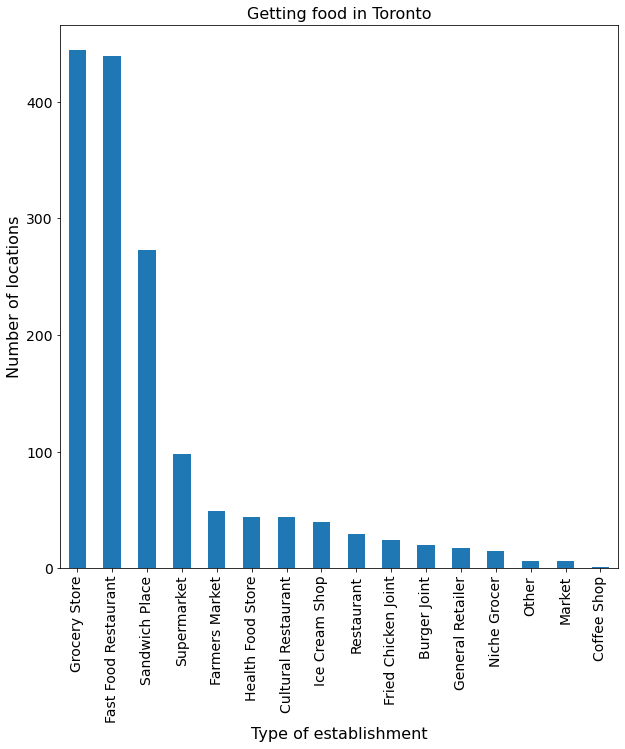

In [203]:
cultural_restaurant =('Asian Restaurant','Caribbean Restaurant',
                      'Chinese Restaurant','Comfort Food Restaurant',
                      'Doner Restaurant','Filipino Restaurant',
                      'Greek Restaurant','Halal Restaurant',
                      'Indian Restaurant','Juice Bar',
                      'Mediterranean Restaurant',
                      'Mexican Restaurant','Middle Eastern Restaurant',
                      'Pizza Place','Portuguese Restaurant',
                      'Poutine Place','Seafood Restaurant',
                      'Salad Place',
                      'Sushi Restaurant','Taco Place',
                      'Tex-Mex Restaurant','Thai Restaurant',
                      'Turkish Restaurant','Vegetarian / Vegan Restaurant',
                      'Wings Joint'
                     )
retailer = ('Big Box Store','Candy Store',
          'Convenience Store','Deli / Bodega',
          'Drugstore','Miscellaneous Shop',
          'Pharmacy','Supplement Shop'
         )
          
          
niche_grocer = ('Butcher','Food & Drink Shop',
                'Gourmet Shop','Organic Grocery',
                'Fruit & Vegetable Store'
               )
other = ('Food Court', 'Food Truck',
         'Food Service',
         'Park'
        )
df_food = df_food.replace(cultural_restaurant,'Cultural Restaurant')
df_food = df_food.replace(retailer,'General Retailer')
df_food = df_food.replace(niche_grocer,'Niche Grocer')
df_food = df_food.replace(other,'Other')


fontsize=16
ticksize=14
df_food['categories'].value_counts()[:].plot(kind='bar',figsize=(10,10))
plt.title('Getting food in Toronto', fontsize = fontsize)
#plt.xlim(0,102)
plt.xlabel('Type of establishment', fontsize = fontsize)
#plt.ylim(0,8)
plt.ylabel('Number of locations', fontsize = fontsize)
plt.xticks(fontsize=ticksize)
plt.yticks(fontsize=ticksize)
plt.show()

Just like we did for the supermarkets, we will perform a cross-join on the food-set with the neighborhood set and then determine which foods are in which neighborhood with the haversine formula and logic.

Defining a subset of the food-set to work with:

In [57]:
df_dest_allfood = df_food.loc[:,['name','categories','lat','lng']]
df_dest_allfood[0:5]

,name,categories,lat,lng
id,,,,
4d053993c2e537043e15bd67,Metro,Supermarket,43.788612,-79.139747
4b59bb58f964a5201a9528e3,Mike & Lori's No Frills,Grocery Store,43.798476,-79.141303
4b46755ff964a520ac2126e3,Coppa's Fresh Market,Grocery Store,43.772094,-79.166340
5ced9661e65d0c002cf70b17,Rouge Naturals,Health Food Store,43.779842,-79.138672
4b847328f964a520293631e3,Food Basics,Supermarket,43.770184,-79.184852


The cartesian product is performed. Then the haversine formula is applied to determine the distance between food and neighborhood locations.

In [58]:
dfx_allfood = df_crossjoin(df_orig, df_dest_allfood, suffixes=('_orig', '_dest'))
dist_allfood = dfx_allfood.apply(lambda row: haversine((row['lat_orig'], row['lng_orig']), (row['lat_dest'], row['lng_dest'])),
                 axis=1)
dfx_allfood['dist'] = dist_allfood


In [61]:
dfx_allfood.index.rename(['Postal_Code','id'],inplace=True)
dfx_allfood[0:5]

lat_orig           lng_orig  \
Postal_Code id                                                              
M1B         4d053993c2e537043e15bd67  43.8113900000001  -79.1966199999999   
            4b59bb58f964a5201a9528e3  43.8113900000001  -79.1966199999999   
            4b46755ff964a520ac2126e3  43.8113900000001  -79.1966199999999   
            5ced9661e65d0c002cf70b17  43.8113900000001  -79.1966199999999   
            4b847328f964a520293631e3  43.8113900000001  -79.1966199999999   

                                                         name  \
Postal_Code id                                                  
M1B         4d053993c2e537043e15bd67                    Metro   
            4b59bb58f964a5201a9528e3  Mike & Lori's No Frills   
            4b46755ff964a520ac2126e3     Coppa's Fresh Market   
            5ced9661e65d0c002cf70b17           Rouge Naturals   
            4b847328f964a520293631e3              Food Basics   

                                             categories   lat_dest   lng_dest  \
Postal_Code id                                                                  
M1B         4d053993c2e537043e15bd67        Supermarket  43.788612 -79.139747   
            4b59bb58f964a5201a9528e3      Grocery Store  43.798476 -79.141303   
            4b46755ff964a520ac2126e3      Grocery Store  43.772094 -79.166340   
            5ced9661e65d0c002cf70b17  Health Food Store  43.779842 -79.138672   
            4b847328f964a520293631e3        Supermarket  43.770184 -79.184852   

                                                  dist  
Postal_Code id                                          
M1B         4d053993c2e537043e15bd67  5217.67389807819  
            4b59bb58f964a5201a9528e3  4663.48709128862  
            4b46755ff964a520ac2126e3  4997.65567567857  
            5ced9661e65d0c002cf70b17  5822.90921761745  
            4b847328f964a520293631e3  4676.09905609004

A test is performed to determine whether or not a food-provider is within a neighborhood.

In [90]:
lt_one_mile = []
lt_one_mile = dfx_allfood['dist'].lt(1609.344) # There are 1.609 km in a mile
dfx_allfood['lt_one_mile'] = lt_one_mile
dfx_allfood.to_csv('dfx_allfood.csv')
dfx_allfood[0:3]

lat_orig           lng_orig  \
Postal_Code id                                                              
M1B         539641d9498ee4f723c48089  43.8113900000001  -79.1966199999999   
            53976a6f498ecd1162705c9a  43.8113900000001  -79.1966199999999   
            4c8fec08de3d236a226d6718  43.8113900000001  -79.1966199999999   

                                                    name     categories  \
Postal_Code id                                                            
M1B         539641d9498ee4f723c48089  Fusion Supermarket    Supermarket   
            53976a6f498ecd1162705c9a    Fusion supermart  Grocery Store   
            4c8fec08de3d236a226d6718     Taj supermarket  Grocery Store   

                                       lat_dest   lng_dest              dist  \
Postal_Code id                                                                 
M1B         539641d9498ee4f723c48089  43.800528 -79.200064  1238.45286346097   
            53976a6f498ecd1162705c9a  43.800434 -79.200439  1255.66704673433   
            4c8fec08de3d236a226d6718  43.818746 -79.210172  1360.08785197445   

                                      lt_one_mile  
Postal_Code id                                     
M1B         539641d9498ee4f723c48089         True  
            53976a6f498ecd1162705c9a         True  
            4c8fec08de3d236a226d6718         True

Food locations that are not within a neighborhood are removed from our target-set.

In [91]:
dfx_allfood = dfx_allfood[dfx_allfood['lt_one_mile'] == True]
dfx_allfood[0:3]

lat_orig           lng_orig  \
Postal_Code id                                                              
M1B         539641d9498ee4f723c48089  43.8113900000001  -79.1966199999999   
            53976a6f498ecd1162705c9a  43.8113900000001  -79.1966199999999   
            4c8fec08de3d236a226d6718  43.8113900000001  -79.1966199999999   

                                                    name     categories  \
Postal_Code id                                                            
M1B         539641d9498ee4f723c48089  Fusion Supermarket    Supermarket   
            53976a6f498ecd1162705c9a    Fusion supermart  Grocery Store   
            4c8fec08de3d236a226d6718     Taj supermarket  Grocery Store   

                                       lat_dest   lng_dest              dist  \
Postal_Code id                                                                 
M1B         539641d9498ee4f723c48089  43.800528 -79.200064  1238.45286346097   
            53976a6f498ecd1162705c9a  43.800434 -79.200439  1255.66704673433   
            4c8fec08de3d236a226d6718  43.818746 -79.210172  1360.08785197445   

                                      lt_one_mile  
Postal_Code id                                     
M1B         539641d9498ee4f723c48089         True  
            53976a6f498ecd1162705c9a         True  
            4c8fec08de3d236a226d6718         True

A dataframe to contain how many of which food-providers are in a neighborhood is prepared. This frame will be joined with the frame that contains the geospatial data for each neighborhood.

In [137]:
categories = pd.Series(['Supermarket','Grocery Store',
              'Fast Food Restaurant','Sandwich Place',
              'Cultural Restaurant','General Retailer',
              'Restaurant', 'Health Food Store', 
              'Fried Chicken Joint','Coffee Shop', 
              'Farmers Market', 'Ice Cream Shop',
              'Burger Joint','Niche Grocer', 
              'Other', 'Market'])
categories.sort_values(inplace=True)
categories_s = categories
df_counts = categories.reset_index(drop=True).to_frame('df_categories').set_index('df_categories').transpose()
df_counts

df_categories,Burger Joint,Coffee Shop,Cultural Restaurant,Farmers Market,Fast Food Restaurant,Fried Chicken Joint,General Retailer,Grocery Store,Health Food Store,Ice Cream Shop,Market,Niche Grocer,Other,Restaurant,Sandwich Place,Supermarket


"For each neighborhood, count how many of each food-category is present. Append this information to a dataframe."

In [138]:
t = True
f = False
columns = [f]*4+[t]*16
for index, row in df.iterrows():
    if index != 'M1X':  # A dirty hack. There are no foods in M1X.
        zone = dfx_allfood.loc[index]['categories']
        dummies = pd.get_dummies(zone)
        counts = dummies.sum().rename(index)
        df_counts = df_counts.append(counts.transpose())
    else:
        continue

We clean up and label our new frame.

In [139]:
df_temp = df_counts.rename_axis('Postal_Code')
df_counts = df_temp.fillna(0)
print(df_counts.shape)
df_counts[0:3]

(102, 16)


df_categories,Burger Joint,Coffee Shop,Cultural Restaurant,Farmers Market,Fast Food Restaurant,Fried Chicken Joint,General Retailer,Grocery Store,Health Food Store,Ice Cream Shop,Market,Niche Grocer,Other,Restaurant,Sandwich Place,Supermarket
Postal_Code,,,,,,,,,,,,,,,,
M1B,0.0,0.0,1.0,0.0,5.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0
M1C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
M1E,0.0,0.0,0.0,0.0,4.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0


The new frame is merged with the original.

In [140]:
df = df.merge(df_counts,'outer', left_on='Postal_Code', right_on='Postal_Code' )
df = df.fillna(0)
df.shape

(103, 20)

In [202]:
df.iloc[:,4:].describe()

,Burger Joint,Coffee Shop,Cultural Restaurant,Farmers Market,Fast Food Restaurant,Fried Chicken Joint,General Retailer,Grocery Store,Health Food Store,Ice Cream Shop,Market,Niche Grocer,Other,Restaurant,Sandwich Place,Supermarket
count,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000
mean,0.359223,0.009709,1.427184,1.252427,9.233010,0.495146,0.145631,8.252427,0.621359,0.427184,0.233010,0.398058,0.427184,0.407767,5.097087,1.980583
std,0.557557,0.098533,2.012714,1.684523,9.098808,0.712270,0.406027,5.661564,0.768453,0.787176,0.468705,0.718656,0.858658,0.550167,4.062054,2.038745
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,6.000000,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000
75%,1.000000,0.000000,2.000000,2.000000,11.500000,1.000000,0.000000,12.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,6.000000,3.000000
max,2.000000,1.000000,8.000000,6.000000,34.000000,2.000000,2.000000,23.000000,3.000000,4.000000,2.000000,3.000000,3.000000,2.000000,16.000000,8.000000


Now that we have the coordinates of each neighborhood in food-space, we can cluster them. First, the data is fit to a KNN-model, calculating the distance to the nearest n-points. The result is sorted and plotted to determine the elbow-point. The elbow point is then used as epsilon in the DBSCAN algorithm to cluster the neighborhoods.

Number of clusters: 3
Epsilon: 3.6


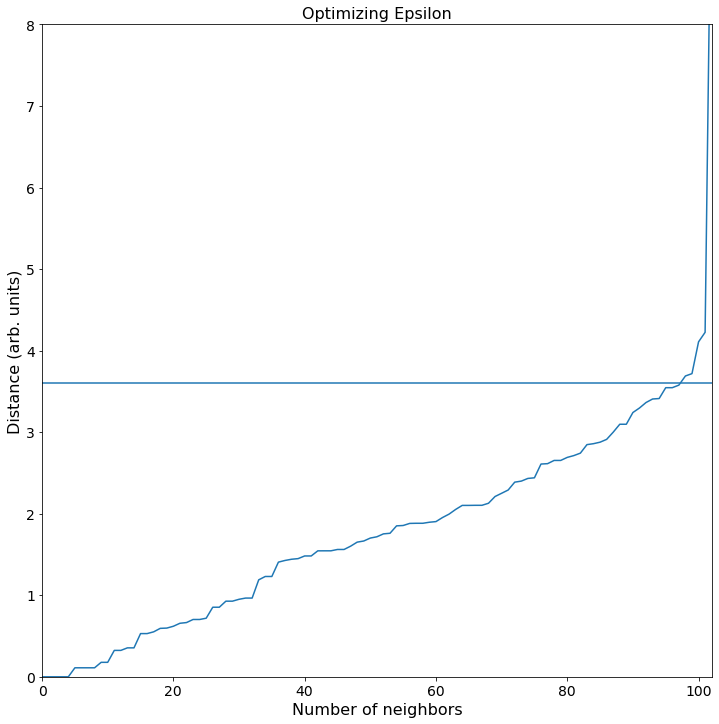

In [188]:
X = df.iloc[:,4:].to_numpy()
y = np.array([])
X = StandardScaler().fit_transform(X)

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

distances = np.sort(distances, axis=0)
distances = distances[:,1]



epsilon = 3.6
minimumSamples = 2
db = DBSCAN(eps=epsilon, min_samples=minimumSamples).fit(X)
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
df_clusters = pd.DataFrame(labels).rename(columns={0:'cluster'})
print("Number of clusters: {}".format(n_clusters_))
print("Epsilon: {}".format(epsilon))

fontsize=16
ticksize=14

plt.figure(figsize=(12, 12))
plt.plot(distances)
plt.axhline(y=epsilon)
plt.title('Optimizing Epsilon', fontsize = fontsize)
plt.xlim(0,102)
plt.xlabel('Number of neighbors', fontsize = fontsize)
plt.ylim(0,8)
plt.ylabel('Distance (arb. units)', fontsize = fontsize)
plt.xticks(fontsize=ticksize)
plt.yticks(fontsize=ticksize)
plt.show()

In [189]:
map_long = df['lng'].mean()
map_lat = df['lat'].mean()
colors = []

for i in range(0,len(set(labels))):    # A loop to create a random color for each one of our labels
    random_number = np.random.randint(0,16777215)
    hex_number = str(hex(random_number))
    hex_number ='#'+ hex_number[2:]
    colors.append(hex_number)

cluster_map = folium.Map(location=[map_lat, map_long],tiles='Stamen Toner', zoom_start=11.25, width =800,height=600)

for lat, lng, hood, index, cluster in zip (df.lat, df.lng, df.Neighborhood,df.index, df_clusters.cluster):
   
    tag = '{}\nCluster: {}'.format(index,cluster)
    
    if cluster == -1:
        col = 'black'
        op = 0.55
        d = 0.005
        nw = [lat+d,lng+d]
        sw = [lat-d,lng+d]
        ne = [lat+d,lng-d]
        se = [lat-d,lng-d]
        folium.Rectangle(
            [nw,sw,ne,se],
            color=col,
            popup=tag,
            fill = True,
            fill_opacity=op,
            stroke=False
        ).add_to(cluster_map)     
       
    else:
        col = colors[cluster]
        op = 1.0
        folium.Circle(
            [lat, lng],
            radius=500,
            color=col,
            popup=tag,
            fill = True,
            #fill_color=[0.0, 0.0, 1.0, 0],
            fill_opacity=op,
            stroke=False
        ).add_to(cluster_map) 
cluster_map

## Results ##
DBSCAN has found three clusters and five outliers. Not surpisingly, DBSCAN found that the core of Toronto has a different food-makeup than the greater metropolitan area. Next steps in this study would be to identify the characteristics of these clusters. In addition, it would be interesting to remove Toronto's core region from the dataset and then recluster the greater metropolitan area. The removal of the core from the set could reveal the food-topolgy of the greater metropolitan area that is being hidden from DBSCAN by the uniqueness of the core-region.